The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


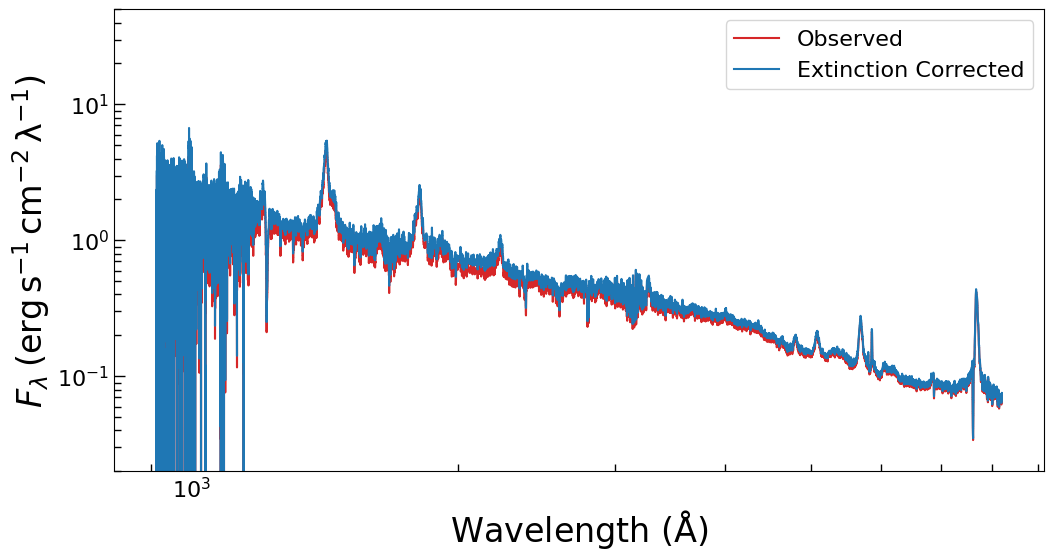

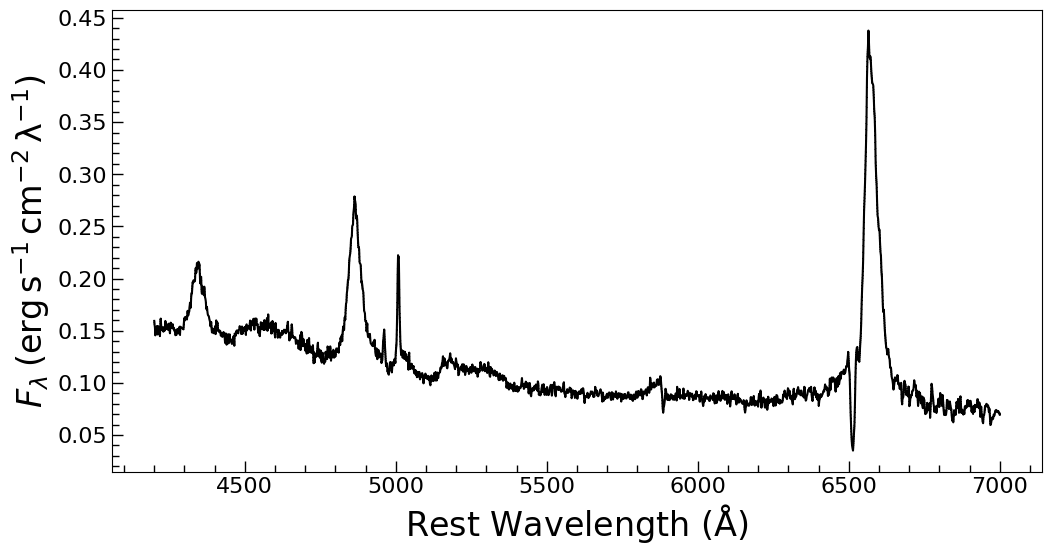

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg1322sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.053    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.1684 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

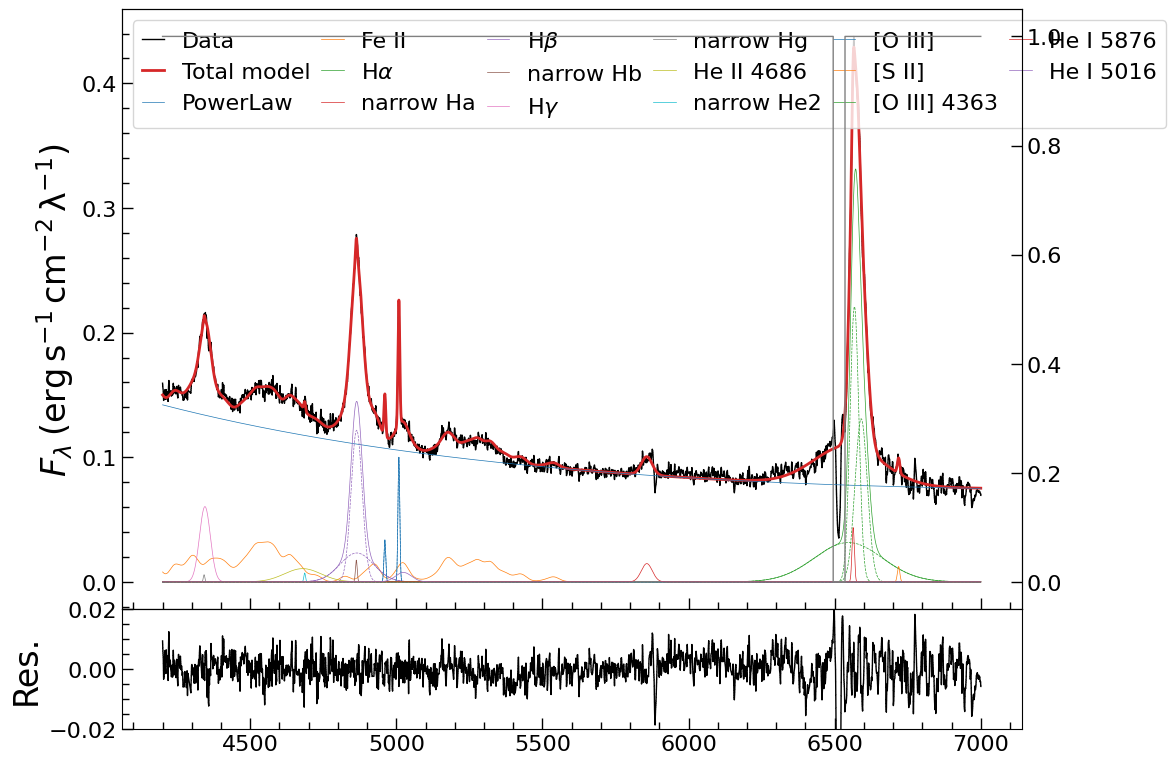

<PowerLaw1D(amplitude=0.09911127, x_0=5500., alpha=1.27242239, name='PowerLaw')>
<IronTemplate(amplitude=0.04497044, stddev=1258.18, z=0.00039247, name='Fe II')>
<Line_MultiGauss(amp_c=0.22549807, dv_c=222.72102125, sigma_c=690.66574378, wavec=6562.819, amp_w0=0.14320833, dv_w0=-1016.90108296, sigma_w0=5317.43165784, amp_w1=0.59151728, dv_w1=1052.34750897, sigma_w1=967.24551136, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.04452614, dv=21.72331053, sigma=185.22874681, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss(amp_c=0.12755585, dv_c=92.60213814, sigma_c=1171.92382143, wavec=4862.721, amp_w0=0.19046766, dv_w0=34.51780736, sigma_w0=3544.20115216, name='H$\\beta$')>
<Line_Gaussian(amplitude=0.01827862, dv=21.72331053, sigma=185.22874681, wavec=4862.721, name='narrow Hb')>
<Line_MultiGauss(amp_c=0.06042057, dv_c=221.90042797, sigma_c=1287.27252631, wavec=4341.785, name='H$\\gamma$')>
<Line_Gaussian(amplitude=0.00572502, dv=21.72331053, sigma=185.22874681, wavec=4341.785, name='n

In [16]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=0.09911127, x_0=5500, alpha=1.27242239, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')  
iron = sagan.IronTemplate(amplitude=0.04497044, stddev=1258.18, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
#b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.27, dv_c=540, sigma_c=1000, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
#                             amp_w0=0.12, dv_w0=-630, sigma_w0=6900)
b_ha = sagan.Line_MultiGauss(n_components=3, amp_c=0.245, dv_c=624, sigma_c=890, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.088, dv_w0=-710, sigma_w0=6900, amp_w1=0.176, dv_w1=-142, sigma_w1=2650)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.12, dv_c=77, sigma_c=1200, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.2, dv_w0=235, sigma_w0=3000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.059, dv_c=210, sigma_c=1350, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=-500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.015, dv_c=-900, sigma_c=900, wavec=5875.624, name='He I 5876')  # Masked

line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.1, amp_c1=0.0347, dv_c=24, sigma_c=100, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.0147, dv_w0=180, sigma_w0=150)
#line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=0.1, amp_c1=0.03, dv_c=50, sigma_c=210, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-1300, sigma_w0=380, amp_w1=0.05, dv_w1=2000, sigma_w1=1000)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.009, amp_c1=0.01,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.3, amp_c1=0.1, dv_c=20, sigma_c=280,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=0.09, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.017, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.0067, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.006, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')

line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked

#line_ha_6375 = sagan.Line_Gaussian(amplitude=0.2, wavec=6375, name=' 6375')
line_Fe3_5047=sagan.Line_Gaussian(amplitude=0.0065, wavec=5047, name='Fe III 5047')
b_he1_5016 = sagan.Line_MultiGauss(n_components=1, amp_c=0.009, dv_c=100, sigma_c=1600, wavec=5016, name='He I 5016',bounds=bounds)

m_init = (pl + iron + line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+b_he1_5016)*poly
#+ line_ha + line_hb + line_hg + line_he2 + line_o3 + line_s2 + n_o3_4363+line_he1+line_Fe3_5047

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 6495) & (wave_use < 6535.4)
fltr11= (wave_use > 4285) & (wave_use < 4430)
fltr12= (wave_use > 4600) & (wave_use < 5080)
fltr13= (wave_use > 5550) & (wave_use < 6050)
fltr14= (wave_use > 6200) & (wave_use < 6890)

weights[fltr1] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
axr.set_ylim(-0.02, 0.02)
plt.show()

for m in m_fit:
    print(m.__repr__())